In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import imageio
import bm3d

from skimage.restoration import denoise_nl_means, estimate_sigma, denoise_tv_chambolle
from skimage import img_as_float, img_as_ubyte, io
from scipy import ndimage as nd
from skimage import measure, color, io

In [2]:
def normalise(img):
    return cv2.normalize(img, dst = None, alpha = 0,
                         beta = 65535, norm_type = cv2.NORM_MINMAX)

def normalise2(img_o):
    return (img_o-np.mean(img_o.flatten()))/(np.max(img_o.flatten())-np.min(img_o.flatten()))

def show_save(img, path):
    plt.imshow(img, cmap='gray')
    plt.imsave(path, img, cmap='gray')

In [32]:
def nlm_denoise(img):
    sigma_est = np.mean(estimate_sigma(img))
    denoise = denoise_nl_means(img, h=1.15*sigma_est, fast_mode=True,
                          patch_size=5, patch_distance=3)
    return img_as_ubyte(denoise)

#removes unwanted detail while preserving important details such as edges
def tv_denoise(img):
    return denoise_tv_chambolle(img, weight = 0.1, eps = 0.002)
#collaborative filtering process
def bm3d_denoise(img):
    return bm3d.bm3d(img, sigma_psd = 0.2,
                     stage_arg = bm3d.BM3DStages.ALL_STAGES)

In [38]:
def means3(denoise_ubyte):
    segm1 = (denoise_ubyte >= 170)
    segm2 = (denoise_ubyte < 170) & (denoise_ubyte >= 120)
    segm3 = (denoise_ubyte < 120)
    all_segments = np.zeros((denoise_ubyte.shape[0], denoise_ubyte.shape[1], 3))
    all_segments[segm2] = (0.5,0.5,0.5)
    all_segments[segm1] = (1,1,1)
    all_segments[segm3] = (0,0,0)
    return all_segments

def means2(denoise_ubyte):
    segm1 = (denoise_ubyte >= 150)
    segm2 = (denoise_ubyte < 150)
    all_segments = np.zeros((denoise_ubyte.shape[0], denoise_ubyte.shape[1], 3))
    all_segments[segm2] = (0,0,0)
    all_segments[segm1] = (1,1,1)
    return all_segments

def kmeans(img, k):
    img2 = img.reshape((-1, 3))
    img2 = np.float32(img2)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts = 10
    ret, label, centre = cv2.kmeans(img2, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    centre = np.uint8(centre)
    res = centre[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2

In [16]:
img1 = cv2.imread(r'C:\Users\sneha\OneDrive\Desktop\Sem_6\OELP\particle_size_detection\SEM_images\136\3_SiC_no_UST02.tif')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

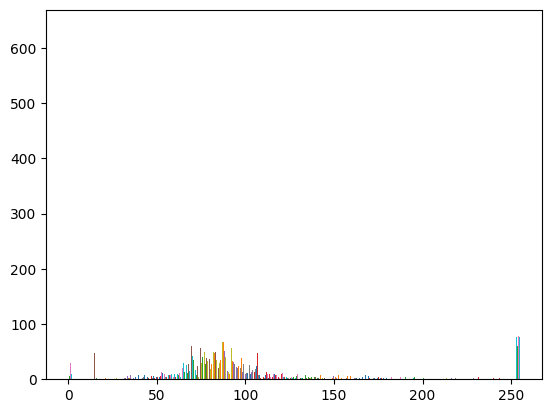

In [17]:
# show_save(img1, 'original.png')
hist = plt.hist(img1, bins=100, range=(0,255))

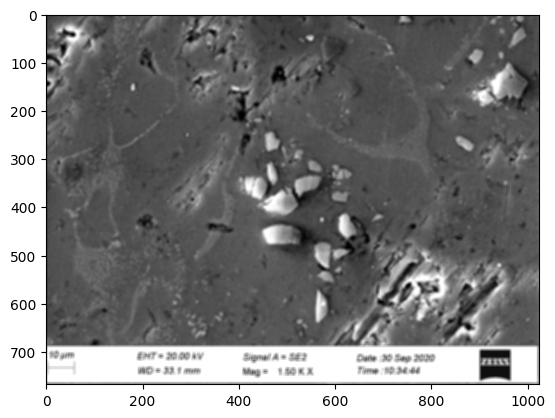

In [29]:
denoised_img1 = nlm_denoise(img1)
plt.imshow(denoised_img1, cmap='gray')
# show_save(denoised_img1, 'nlm_denoise.png')
# hist = plt.hist(denoised_img1, bins=100, range=(0,255))

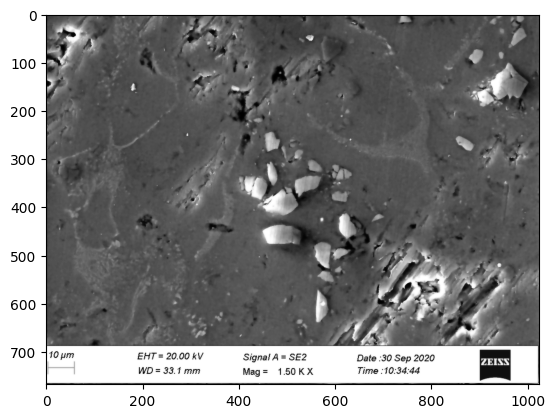

In [33]:
denoised_img2 = tv_denoise(img1)
plt.imshow(denoised_img2, cmap='gray')
# show_save(denoised_img2, 'tv_denoise.png')
# hist = plt.hist(denoised_img2, bins=100, range=(0,255))
# use hist and watershed or Otsu and watershed

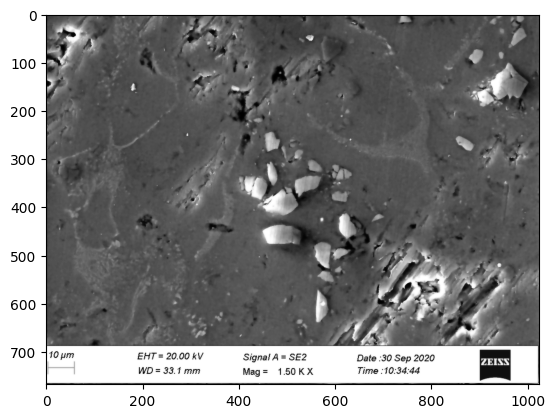

In [34]:
denoised_img3 = tv_denoise(img1)
plt.imshow(denoised_img3, cmap='gray')
# show_save(denoised_img3, 'bm3d_denoise.png')
# hist = plt.hist(denoised_img3, bins=100, range=(0,255))

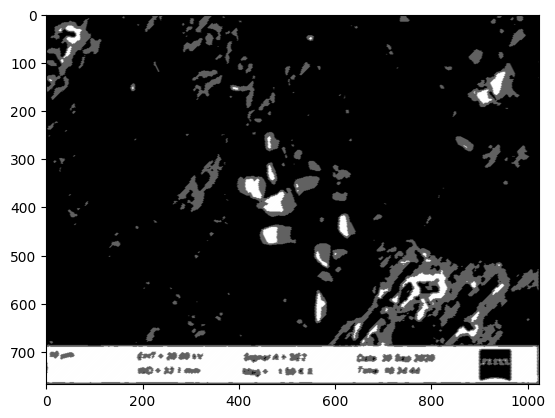

In [40]:
kmeans_3 = kmeans(denoised_img1, 3)
kmeans_4 = kmeans(denoised_img1, 4)
# show_save(kmeans_3, 'kmeans_3.png')
# show_save(kmeans_4, 'kmeans_4.png')

plt.imshow(kmeans_3, cmap='gray', label = 'kmeans=3')

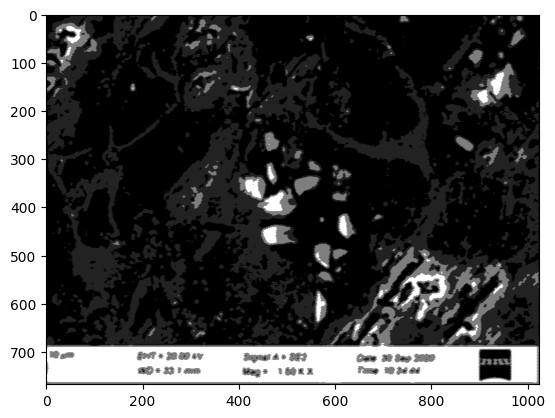

In [41]:
plt.imshow(kmeans_4, cmap='gray', label = 'kmeans=4')

In [49]:
def color_quantization(img, k):
    
    data = np.float32(img).reshape((-1,3))
    
    criteria = (cv2.TERM_CRITERIA_MAX_ITER, 20, 0.001)
    
    ret, label, center = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    
    result = center[label.flatten()]
    result = result.reshape(img.shape)
    
    return result

def otsu(img):
    th = 0
    max_val = 255
    
    ret, o1 = cv2.threshold(img, th, max_val, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
    ret, o2 = cv2.threshold(img, th, max_val, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    ret, o3 = cv2.threshold(img, th, max_val, cv2.THRESH_TOZERO + cv2.THRESH_OTSU )
    ret, o4 = cv2.threshold(img, th, max_val, cv2.THRESH_TOZERO_INV + cv2.THRESH_OTSU )
    ret, o5 = cv2.threshold(img, th, max_val, cv2.THRESH_TRUNC + cv2.THRESH_OTSU )
    
    output = [img, o1, o2, o3, o4, o5]
    return output

def edge_mask(img, line_size, blur_value):
    
    edges = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, line_size, blur_value)
    return edges

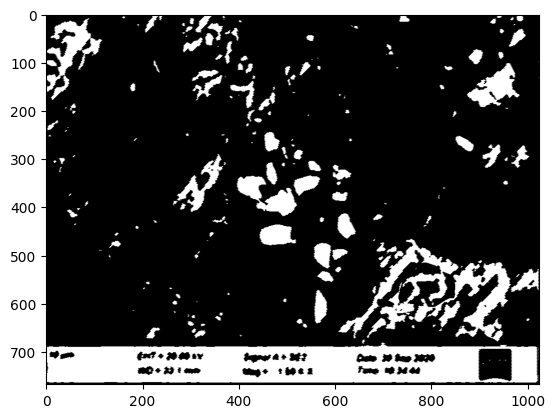

In [53]:
img_otsu1 = otsu(denoised_img1)
img_k3 = color_quantization(img_otsu1[0], k=3)
line_size, blur_value = 99,-10
img_masked_k3 = edge_mask(img_k3, line_size, blur_value)
plt.imshow(img_masked_k3, cmap='gray', label = 'kmeans=3,mask')

In [78]:
# this doesn't use watershed
def contours(img, pixels_to_um, filename, c):
    # Clean up image, if needed (erode, etc.) and create a mask for grains
    kernel = np.ones((3,3),np.uint8)
    if c == True:
        eroded = cv2.erode(img,kernel,iterations = 1)
        dilated = cv2.dilate(eroded,kernel,iterations = 1)

        # Now, we need to apply threshold, meaning convert uint8 image to boolean.
        mask = dilated == 255  #Sets TRUE for all 255 valued pixels and FALSE for 0
    else:
        mask = img == 255
    
    #use 8-connectivity, diagonal pixels will be included as part of a structure
    #this is ImageJ default but we have to specify this for Python, or 4-connectivity will be used
    # 4 connectivity would be [[0,1,0],[1,1,1],[0,1,0]]
    s = [[1,1,1],[1,1,1],[1,1,1]]
    
    #label_im, nb_labels = ndimage.label(mask)
    labeled_mask, num_labels = nd.label(mask, structure=s)
    
    #Let's color the labels to see the effect
    img2 = color.label2rgb(labeled_mask, bg_label=0)
    plt.imshow(img2, cmap='gray')

    # Measure the properties of each grain (object)
    clusters = measure.regionprops(labeled_mask, img)
    # Step 6: Output results into a csv file   
    # Best way is to output all properties to a csv file

    propList = ['Area',
                'equivalent_diameter',
                'orientation',
                'MajorAxisLength',
                'MinorAxisLength',
                'Perimeter',
                'MinIntensity',
                'MeanIntensity',
                'MaxIntensity']
    
    output_file = open(filename, 'w')
    output_file.write(',' + ",".join(propList) + '\n') 
    # join strings in array by commas, leave first cell blank
    # First cell blank to leave room for header (column names)

    for cluster_props in clusters:
        # output cluster properties to the excel file
        output_file.write(str(cluster_props['Label']))
        for i,prop in enumerate(propList):
            if(prop == 'Area'): 
                to_print = cluster_props[prop]*pixels_to_um**2   # Convert pixel square to um square
            elif(prop == 'orientation'): 
                to_print = cluster_props[prop]*57.2958  # Convert to degrees from radians
            elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
                to_print = cluster_props[prop]*pixels_to_um
            else:
                to_print = cluster_props[prop]     # Reamining props, basically the ones with Intensity in its name
            output_file.write(',' + str(to_print))
        output_file.write('\n')
    output_file.close()

(768, 1024)


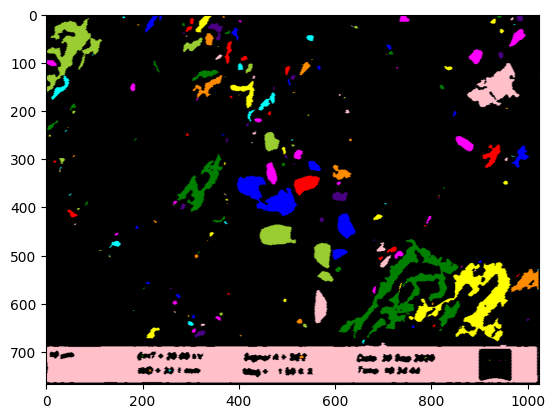

In [85]:
# this doesn't use erosion and dilation
contours(img_masked_k3, 0.1823, "image_measurements.csv", False)

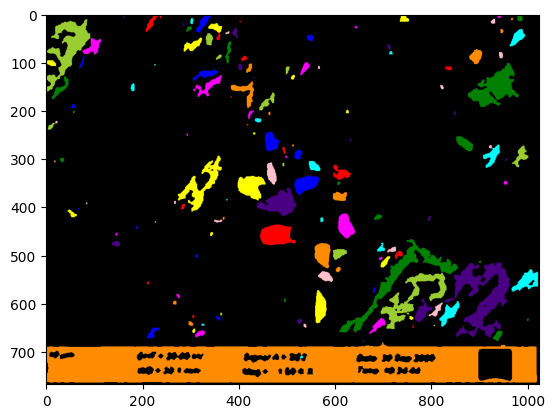

In [80]:
# this uses erode and dilate
contours(img_masked_k3, 0.1823, "image_measurements.csv", True)

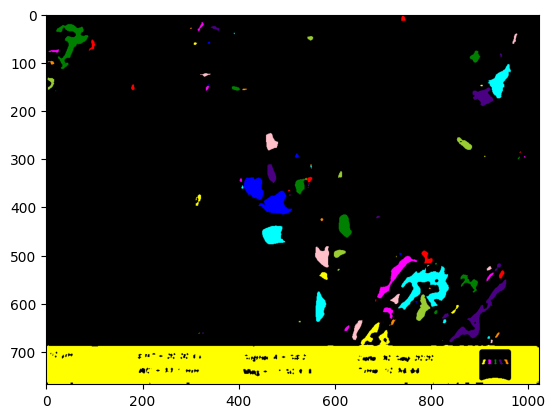

In [86]:
# just normal otsu
ret, thresh = cv2.threshold(denoised_img1, 0, 255, cv2.THRESH_OTSU)
contours(thresh, 0.1823, "image_measurements.csv", False)

In [ ]:
def contours_watershed(img, pixels_to_um, filename, c):
    